# Analyse netowkr results from Pypsa-Earth-Sec
This notebook reads the latest optimization described in the config.yaml file and makes plots and summaries of the results.

Sources: 
- Statistics module: https://pypsa.readthedocs.io/en/latest/examples/statistics.html
- Template: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/network_analysis.ipynb

File is needed:
* PyPSA network file (.nc) includes the heating, transprot, and electricity demand information.

## Import packages

In [16]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import sys
import xarray as xr
import cartopy

## Path settings
This section reads the config parameters from your config.yaml file and automatically reads the output of the optimization with those settings

In [18]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# Set your network path (.nc) here
network_path = "/home/pypsa-earth-sec/results/elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc"
n = pypsa.Network(network_path)

Index(['H2 pipeline NZ.15_1 -> NZ.17_1', 'H2 pipeline NZ.17_1 -> NZ.1_1',
       'H2 pipeline NZ.1_1 -> NZ.11_1'],
      dtype='object', name='name')
Index(['H2 pipeline NZ.15_1 -> NZ.17_1', 'H2 pipeline NZ.17_1 -> NZ.1_1',
       'H2 pipeline NZ.1_1 -> NZ.11_1'],
      dtype='object', name='name')
INFO:pypsa.io:Imported network elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Data import check

List number of components by type

In [3]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 318 entries
Component 'Carrier' has 37 entries
Component 'GlobalConstraint' has 2 entries
Component 'Line' has 17 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 809 entries
Component 'Load' has 461 entries
Component 'Generator' has 136 entries
Component 'StorageUnit' has 6 entries
Component 'Store' has 197 entries


List the snapshots of the PyPSA network

In [4]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00', '2013-01-01 15:00:00',
               '2013-01-01 18:00:00', '2013-01-01 21:00:00',
               '2013-01-02 00:00:00', '2013-01-02 03:00:00',
               ...
               '2013-12-30 18:00:00', '2013-12-30 21:00:00',
               '2013-12-31 00:00:00', '2013-12-31 03:00:00',
               '2013-12-31 06:00:00', '2013-12-31 09:00:00',
               '2013-12-31 12:00:00', '2013-12-31 15:00:00',
               '2013-12-31 18:00:00', '2013-12-31 21:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2920, freq=None)
Time steps: 2920


## Analyse energy system

### Transport Sector 
The demand of EVs, ICE (internal combustion engine) and FCEV (fuell cell)

In [5]:
load_stats = n.statistics.energy_balance(comps=["Load"], aggregate_time="mean")
transport_stats = load_stats[load_stats.index.get_level_values('carrier').str.contains(
    'land transport oil(?! emissions)|land transport fuel cell|land transport EV', 
    case=True)]
transport_stats

      carrier                   bus_carrier
Load  land transport EV         Li ion         -470.260030
      land transport fuel cell  H2             -235.130015
      land transport oil        oil           -5878.250369
dtype: float64

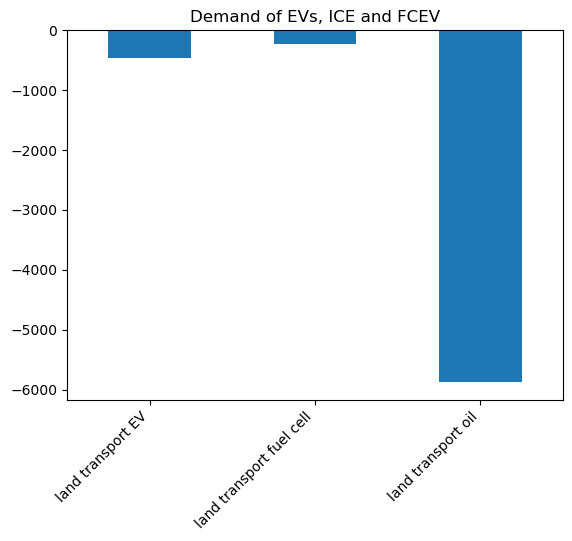

In [6]:
ax = transport_stats.plot.bar(
    title='Demand of EVs, ICE and FCEV',
    xlabel=""
)

ax.set_xticklabels(transport_stats.index.get_level_values('carrier'), rotation=45, ha="right")
plt.show()

### Heating Sector 
The demand of various heating subsectors

In [7]:
load_stats = n.statistics.energy_balance(comps=["Load"], aggregate_time="mean")
heating_stats = load_stats[load_stats.index.get_level_values('carrier').str.contains('heat', case=False)]
heating_stats

      carrier                            bus_carrier                     
Load  low-temperature heat for industry  urban central heat                 -249.747297
      residential rural heat             residential rural heat               -1.420954
      residential urban decentral heat   residential urban decentral heat    -10.224502
      services rural heat                services rural heat                  -1.357948
      services urban decentral heat      services urban decentral heat        -9.771145
      urban central heat                 urban central heat                  -30.517161
dtype: float64

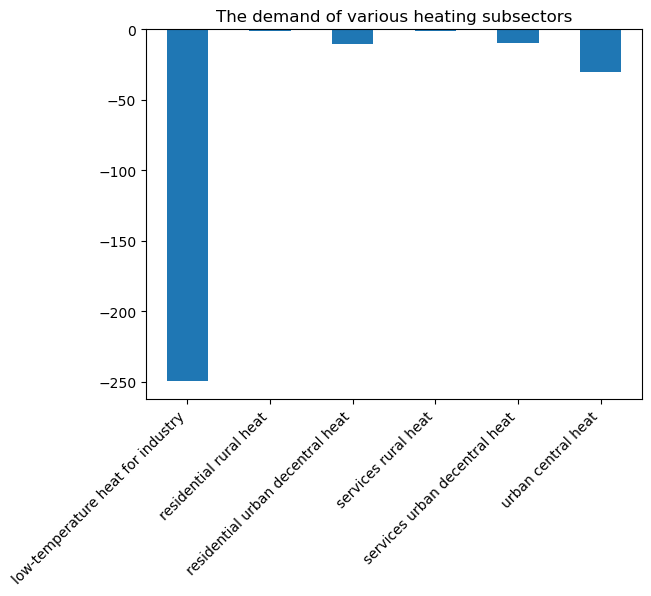

In [8]:
ax = heating_stats.plot.bar(
    title='The demand of various heating subsectors',
    xlabel=""
)

ax.set_xticklabels(heating_stats.index.get_level_values('carrier'), rotation=45, ha="right")
plt.show()


How is heating energy supplied (heat pump, district heating, resistive heater, gas boiler)

In [9]:
heating_supply_stats = n.statistics.supply(comps=["Link"], aggregate_time="mean").loc[
    lambda x: x.index.get_level_values('carrier').str.contains('heat|boiler|pump|resistive', case=False)
]

heating_types = ['Gas Boiler', 'Heat Pump', 'Resistive Heater']
heating_sums = [heating_supply_stats[heating_supply_stats.index.get_level_values('carrier').str.contains(ht, case=False)].sum() for ht in heating_types]
heating_sums

[274.9255349451954, 0.2902017678572082, 27.878132885439577]

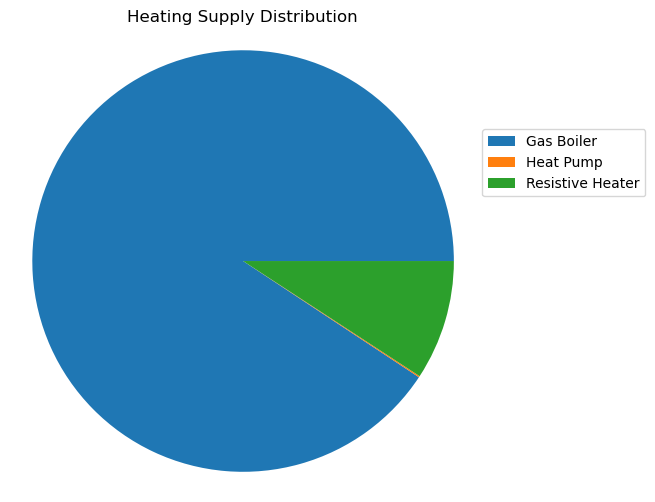

In [10]:
plt.figure(figsize=(6, 6))
plt.pie(heating_sums)
plt.title('Heating Supply Distribution')
plt.legend(heating_types, loc='upper left', bbox_to_anchor=(1, 0.8))
plt.axis('equal')
plt.show()

### Electricity Sector 
The share of different carriers (capacity and energy)

In [11]:
capacity_stats = n.statistics.installed_capacity(comps=["Generator"])
electricity_capacity_stats = capacity_stats[~capacity_stats.index.get_level_values('carrier').str.contains('thermal|gas')]
electricity_capacity_stats

           carrier           
Generator  Coal                   500.000000
           Combined-Cycle Gas    1838.950905
           Offshore Wind (AC)       0.000000
           Offshore Wind (DC)       0.000000
           Oil                    150.066350
           Onshore Wind           784.000000
           Open-Cycle Gas         543.978622
           Run of River           398.225382
           Solar                  142.074179
Name: p_nom, dtype: float64

<AxesSubplot:title={'center':'Share of different carriers by capacity'}>

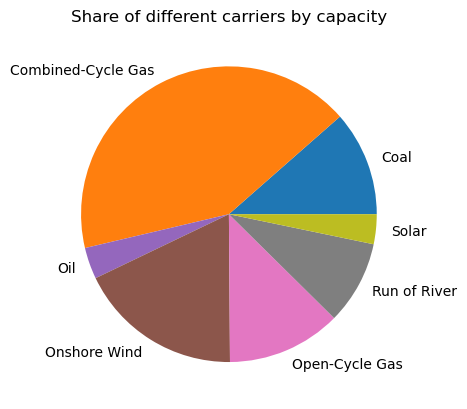

In [12]:
electricity_capacity_stats.plot.pie(
    title="Share of different carriers by capacity",
    labels=electricity_capacity_stats.index.get_level_values('carrier'),
    ylabel=""
)

In [13]:
energy_stats = n.statistics.energy_balance(comps=["Generator"])
electricity_energy_stats = energy_stats[energy_stats.index.get_level_values('bus_carrier') == 'AC']
electricity_energy_stats

           carrier             bus_carrier
Generator  Coal                AC             3.868327e+06
           Combined-Cycle Gas  AC             2.546595e+06
           Geothermal          AC             9.810376e+06
           Offshore Wind (AC)  AC             3.824497e+00
           Offshore Wind (DC)  AC             4.224329e+00
           Oil                 AC             2.252209e+03
           Onshore Wind        AC             2.748346e+07
           Open-Cycle Gas      AC             8.237255e+04
           Run of River        AC             2.781699e+06
           Solar               AC             2.045476e+07
Name: generators, dtype: float64

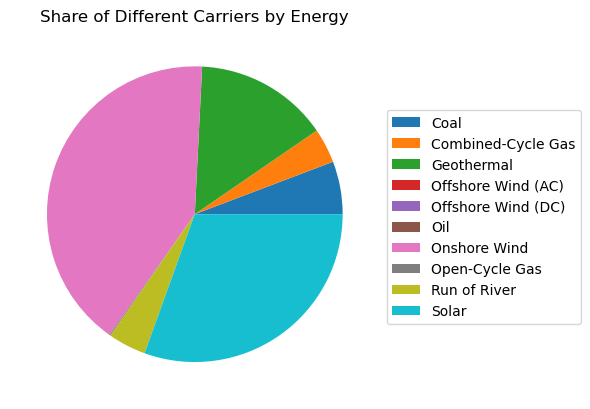

In [14]:
electricity_energy_stats.plot.pie(
    title='Share of Different Carriers by Energy',
    labels=None,
    ylabel=""
)

# Using legend because of overlapping carriers
custom_labels = electricity_energy_stats.index.get_level_values("carrier")
plt.legend(custom_labels, loc='upper left', bbox_to_anchor=(1, 0.8))
plt.show()